# Big-Data Analytics: Traffic accidents in United Kingdom from 2005 to 2018

The aim of this project is to analyze the traffic accidents dataset of the United Kingdom for the period 2008 until 2018. The dataset contains granular information about accidents, involved vehicles, and casualties over a period of 14 years. We want to gain insights into various interesting questions, e.g. which age-group causes most accidents, what time of the day is especially prone to accidents, how do speed limits relate to accident severity, and many more interesting questions. We try to follow a more scientific approach by stating hypotheses first, and then using the data to answer our hypotheses, where most of the times simple plots are sufficient.

**Course**: Big-Data Analytics, University of Zurich, Spring 2020

**Instructor**: Dr. Sven Helmer

**Authors**: Rino Beeli (15-709-371), Yannik Haller (12-918-645), Wenxi Feng (18-745-257)

**Group**: 2

---

We first make sure that all packages used throughout this Jupyter notebook are installed and loaded (expect for the last parts using kepler.gl, TensorFlow and Keras).

In [5]:
!pip install pandas numpy matplotlib sklearn
import os
import sys
import glob
import pandas as pd
import numpy as np
import urllib.request                     # HTTP downloader
from zipfile import ZipFile               # ZIP file decompressor
import matplotlib.pyplot as plt           # plotting

In [6]:
print (sys.version)

3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]


We have implemented and tested this notebook using **Python 3.6.9** and **Jupyter Lab 2.1.3**, therefore recommend to use the same/compatible versions of Python/Jupyter Lab.

# Raw data collection

The **raw data files** are automatically downloaded from the website of the [Department for Transport of the United Kingdom](https://www.gov.uk/government/organisations/department-for-transport) into the file system folder **uktraffic** of your current working directory, if they haven't been loaded already (684 MB uncompressed):

In [7]:
# folder containing all csv files
path = 'uktraffic/'
print(f'Working directory: \t {os.getcwd()}')
print(f'Data directory: \t {os.getcwd()}/{path}')

Working directory: 	 /home/rino/bigdataroot
Data directory: 	 /home/rino/bigdataroot/uktraffic/


Download ZIP data files:

In [8]:
# create data folder
os.makedirs(path, exist_ok=True)

def download(url, target):
    """ URL download function - stores the file into the `uktraffic` folder. """
    filename = os.path.split(url)
    target = os.path.join(target, filename[1])
    urllib.request.urlretrieve(url, target)
    return target
    
# download ZIP files and decompress if not already done
if not os.path.isfile(path + '2018/dftRoadSafetyData_Accidents_2018.csv'):
    zips = [
        # 2005-2014
        ['0514', download('http://data.dft.gov.uk.s3.amazonaws.com/road-accidents-safety-data/Stats19_Data_2005-2014.zip', path)],
        # 2015
        ['2015', download('http://data.dft.gov.uk/road-accidents-safety-data/RoadSafetyData_2015.zip', path)],
        # 2016
        ['2016', download('http://data.dft.gov.uk/road-accidents-safety-data/dftRoadSafetyData_Casualties_2016.zip', path)],
        ['2016', download('http://data.dft.gov.uk/road-accidents-safety-data/dftRoadSafetyData_Vehicles_2016.zip', path)],
        ['2016', download('http://data.dft.gov.uk/road-accidents-safety-data/dftRoadSafety_Accidents_2016.zip', path)],
        # 2017
        ['2017', download('http://data.dft.gov.uk.s3.amazonaws.com/road-accidents-safety-data/dftRoadSafetyData_Vehicles_2017.zip', path)],
        ['2017', download('http://data.dft.gov.uk.s3.amazonaws.com/road-accidents-safety-data/dftRoadSafetyData_Casualties_2017.zip', path)],
        ['2017', download('http://data.dft.gov.uk.s3.amazonaws.com/road-accidents-safety-data/dftRoadSafetyData_Accidents_2017.zip', path)]
    ]
    
    # 2018
    os.makedirs(path + '2018', exist_ok=True)
    download('http://data.dft.gov.uk/road-accidents-safety-data/dftRoadSafetyData_Accidents_2018.csv', path + '2018')
    download('http://data.dft.gov.uk/road-accidents-safety-data/dftRoadSafetyData_Casualties_2018.csv', path + '2018')
    download('http://data.dft.gov.uk/road-accidents-safety-data/dftRoadSafetyData_Vehicles_2018.csv', path + '2018')
    
    # unzip files
    for item in zips:
        os.makedirs(path + item[0], exist_ok=True)
        with ZipFile(item[1], 'r') as z: z.extractall(path + item[0])  # extract zip
        os.remove(item[1])  # delete zip file
        
# list all CSV files
glob.glob(path + '/**/*.csv', recursive=True)

['uktraffic/2015/Accidents_2015.csv',
 'uktraffic/2015/Vehicles_2015.csv',
 'uktraffic/2015/Casualties_2015.csv',
 'uktraffic/0514/Vehicles0514.csv',
 'uktraffic/0514/Casualties0514.csv',
 'uktraffic/0514/Accidents0514.csv',
 'uktraffic/2016/dftRoadSafety_Accidents_2016.csv',
 'uktraffic/2016/Veh.csv',
 'uktraffic/2016/Cas.csv',
 'uktraffic/2018/dftRoadSafetyData_Accidents_2018.csv',
 'uktraffic/2018/dftRoadSafetyData_Casualties_2018.csv',
 'uktraffic/2018/dftRoadSafetyData_Vehicles_2018.csv',
 'uktraffic/2017/Acc.csv',
 'uktraffic/2017/Veh.csv',
 'uktraffic/2017/Cas.csv']

# Data processing (parse, merge)

The next step is to load the data files with the columns of interest, and merge the files for all years. Note that the files downloaded have very different filenames, therefore we manually concat them:

## Accidents

In [9]:
import pandas as pd

cols = {'Accident_Index': str,
        'Longitude': float,
        'Latitude': float,
        'Accident_Severity': int,
        'Number_of_Vehicles': int,
        'Number_of_Casualties': int,
        'Date': str,
        'Time': str,
        '1st_Road_Class': int,
        '1st_Road_Number': int,
        'Road_Type': int,
        'Speed_limit': float,
        'Junction_Detail': int,
        'Junction_Control': int,
        '2nd_Road_Class': int,
        '2nd_Road_Number': int,
        'Light_Conditions': int,
        'Weather_Conditions': int,
        'Road_Surface_Conditions': int,
        'Special_Conditions_at_Site': int,
        'Urban_or_Rural_Area': int}

files = [
    path + '0514/Accidents0514.csv',
    path + '2015/Accidents_2015.csv',
    path + '2016/dftRoadSafety_Accidents_2016.csv',
    path + '2017/Acc.csv',
    path + '2018/dftRoadSafetyData_Accidents_2018.csv'
]

# load files as pandas.DataFrame
pds = [pd.read_csv(f, usecols=list(cols.keys()), dtype=cols, parse_dates=['Date'], dayfirst=True) for f in files]

# merge accidents files for all years
acc = pd.concat(pds, ignore_index=True)

## Casualties

In [10]:
cols = {'Accident_Index': str,
        'Vehicle_Reference': int,
        'Casualty_Reference': int,
        'Casualty_Class': int,
        'Sex_of_Casualty': int,
        'Age_of_Casualty': int,
        'Casualty_Severity': int,
        'Car_Passenger': int,
        'Casualty_Type': int,
        'Casualty_Home_Area_Type': int}

files = [
    path + '0514/Casualties0514.csv',
    path + '2015/Casualties_2015.csv',
    path + '2016/Cas.csv',
    path + '2017/Cas.csv',
    path + '2018/dftRoadSafetyData_Casualties_2018.csv'
]

# load files as pandas.DataFrame
pds = [pd.read_csv(f, usecols=list(cols.keys()), dtype=cols) for f in files]

# merge casualties files for all years
cas = pd.concat(pds, ignore_index=True)

## Vehicles

In [11]:
cols = {'Accident_Index': str,
        'Vehicle_Reference': int,
        'Vehicle_Type': int,
        'Vehicle_Manoeuvre': int,
        'Junction_Location': int,
        'Skidding_and_Overturning': int,
        'Was_Vehicle_Left_Hand_Drive?': int,
        'Journey_Purpose_of_Driver': int,
        'Sex_of_Driver': int,
        'Age_of_Driver': int,
        'Engine_Capacity_(CC)': int,
        'Propulsion_Code': int,
        'Age_of_Vehicle': int}

files = [
    path + '0514/Vehicles0514.csv',
    path + '2015/Vehicles_2015.csv',
    path + '2016/Veh.csv',
    path + '2017/Veh.csv',
    path + '2018/dftRoadSafetyData_Vehicles_2018.csv'
]

# load files as pandas.DataFrame
pds = [pd.read_csv(f, usecols=list(cols.keys()), dtype=cols) for f in files]

# merge vehicles files for all years
veh = pd.concat(pds, ignore_index=True)

## Miscellaneous

We define labels and abbreviations used throughout the analysis here.

In [12]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekdays_abbr = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# Data cleaning

The goal of this step is to remove erroneous records, rectify possible artifacts, and ensure that all fields have the correct data type and representation (unit, format). The value `-1` for categorical variables means **Value missing or out of range**, but we will not remove it in this process and instead consider it depending on the analysis later on. Also, the value `0` for categorical variables usually denotes *None* or *Not applicable*.

## Accidents

In [13]:
acc

,Accident_Index,Longitude,Latitude,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Time,1st_Road_Class,1st_Road_Number,...,Speed_limit,Junction_Detail,Junction_Control,2nd_Road_Class,2nd_Road_Number,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Urban_or_Rural_Area
0,200501BS00001,-0.191170,51.489096,2,1,1,2005-01-04,17:42,3,3218,...,30.0,0,-1,-1,0,1,2,2,0,1
1,200501BS00002,-0.211708,51.520075,3,1,1,2005-01-05,17:36,4,450,...,30.0,6,2,5,0,4,1,1,0,1
2,200501BS00003,-0.206458,51.525301,3,2,1,2005-01-06,00:15,5,0,...,30.0,0,-1,-1,0,4,1,1,0,1
3,200501BS00004,-0.173862,51.482442,3,1,1,2005-01-07,10:35,3,3220,...,30.0,0,-1,-1,0,1,1,1,0,1
4,200501BS00005,-0.156618,51.495752,3,1,1,2005-01-10,21:13,6,0,...,30.0,0,-1,-1,0,7,1,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2169886,2018984115718,-3.461918,55.232746,3,2,1,2018-12-23,13:45,3,701,...,60.0,0,-1,-1,0,1,1,2,0,2
2169887,2018984115918,-3.360440,55.116374,3,2,1,2018-12-24,10:45,2,74,...,70.0,0,-1,-1,0,1,1,1,0,1
2169888,2018984116018,-3.264352,55.058510,3,3,1,2018-12-20,18:00,4,7076,...,30.0,0,-1,-1,0,4,1,2,0,2
2169889,2018984116318,-3.269695,54.990344,2,1,1,2018-12-24,11:50,5,50,...,60.0,3,4,6,552,1,1,4,0,2


In [15]:
# remove rows without time (only 169 out of ~2.1M)
rm_acc_idxs = acc[acc['Time'].isnull()]['Accident_Index']

acc = acc[~acc['Accident_Index'].isin(rm_acc_idxs)].copy()
cas = cas[~cas['Accident_Index'].isin(rm_acc_idxs)].copy()
veh = veh[~veh['Accident_Index'].isin(rm_acc_idxs)].copy()

print(f'Removed {rm_acc_idxs.shape[0]} rows because of missing Time values')

Removed 0 rows because of missing Time values


The **`Time`** column is given as a string and formatted as `HH:MM`, we want it as a decimal number representing hours (new column **`Time Hours`**):

In [16]:
acc['Time Hours'] = pd.to_datetime(acc['Time'], format='%H:%M').dt.time.apply(lambda x: x.hour + x.minute/60).astype(float)

Also, we want the hour as an integer for grouping purposes. To do so, we create a new column called **`Hour of Day`**:

In [17]:
acc['Hour of Day'] = acc['Time Hours'].astype(int)

Analogously, we do the same for the weekdays and years:

In [18]:
acc['Year'] = acc['Date'].dt.year.astype(int)
acc['Day of Week'] = acc['Date'].dt.weekday + 1  # 1 = Monday, 7 = Sunday

The **`Accident_Severity`** column takes the values `1 = Fatal`, `2 = Serious`, `3 = Slight`. We reverse the numbering to get more meaningful values for a more intuitive interpretation: `1 = Slight`, `2 = Serious`, `3 = Fatal`.



In [19]:
acc['Accident_Severity'] = 4 - acc['Accident_Severity']

In [20]:
acc.dtypes

Accident_Index                        object
Longitude                            float64
Latitude                             float64
Accident_Severity                      int64
Number_of_Vehicles                     int64
Number_of_Casualties                   int64
Date                          datetime64[ns]
Time                                  object
1st_Road_Class                         int64
1st_Road_Number                        int64
Road_Type                              int64
Speed_limit                          float64
Junction_Detail                        int64
Junction_Control                       int64
2nd_Road_Class                         int64
2nd_Road_Number                        int64
Light_Conditions                       int64
Weather_Conditions                     int64
Road_Surface_Conditions                int64
Special_Conditions_at_Site             int64
Urban_or_Rural_Area                    int64
Time Hours                           float64
Hour of Da

After careful inspection, we are sure that all variables have the correct data types.

## Casualties

In [21]:
cas

,Accident_Index,Vehicle_Reference,Casualty_Reference,Casualty_Class,Sex_of_Casualty,Age_of_Casualty,Casualty_Severity,Car_Passenger,Casualty_Type,Casualty_Home_Area_Type
0,200501BS00001,1,1,3,1,37,2,0,0,1
1,200501BS00002,1,1,2,1,37,3,0,11,1
2,200501BS00003,2,1,1,1,62,3,0,9,1
3,200501BS00004,1,1,3,1,30,3,0,0,1
4,200501BS00005,1,1,1,1,49,3,0,3,-1
...,...,...,...,...,...,...,...,...,...,...
2915878,2018984115718,2,1,2,2,59,3,1,9,3
2915879,2018984115918,1,1,3,1,39,3,0,0,1
2915880,2018984116018,2,1,2,1,18,3,1,9,2
2915881,2018984116318,1,1,1,1,60,2,0,2,3


In [22]:
cas.dtypes

Accident_Index             object
Vehicle_Reference           int64
Casualty_Reference          int64
Casualty_Class              int64
Sex_of_Casualty             int64
Age_of_Casualty             int64
Casualty_Severity           int64
Car_Passenger               int64
Casualty_Type               int64
Casualty_Home_Area_Type     int64
dtype: object

The variables are properly formatted and have the correct type, hence nothing to do here.

## Vehicles

In [23]:
veh

,Accident_Index,Vehicle_Reference,Vehicle_Type,Vehicle_Manoeuvre,Junction_Location,Skidding_and_Overturning,Was_Vehicle_Left_Hand_Drive?,Journey_Purpose_of_Driver,Sex_of_Driver,Age_of_Driver,Engine_Capacity_(CC),Propulsion_Code,Age_of_Vehicle
0,200501BS00001,1,9,18,0,0,1,15,2,74,-1,-1,-1
1,200501BS00002,1,11,4,3,0,1,1,1,42,8268,2,3
2,200501BS00003,1,11,17,0,0,1,1,1,35,8300,2,5
3,200501BS00003,2,9,2,0,0,1,15,1,62,1762,1,6
4,200501BS00004,1,9,18,0,0,1,15,2,49,1769,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3980100,2018984116018,1,9,9,0,0,1,6,1,67,998,1,4
3980101,2018984116018,2,9,15,0,1,1,6,1,24,3000,2,21
3980102,2018984116018,3,9,2,0,0,1,6,3,-1,2400,2,5
3980103,2018984116318,1,2,18,1,1,1,1,1,60,49,1,10


In [24]:
veh.dtypes

Accident_Index                  object
Vehicle_Reference                int64
Vehicle_Type                     int64
Vehicle_Manoeuvre                int64
Junction_Location                int64
Skidding_and_Overturning         int64
Was_Vehicle_Left_Hand_Drive?     int64
Journey_Purpose_of_Driver        int64
Sex_of_Driver                    int64
Age_of_Driver                    int64
Engine_Capacity_(CC)             int64
Propulsion_Code                  int64
Age_of_Vehicle                   int64
dtype: object

In the next step we remove all accidents and related rows for which the field *Vehicle_Type* has no value. We first check the fraction of missing `Vehicle_Type` values per year. It should be approximately constant/small over the time, otherwise a systematic data collection change has been made, which would bias our results.

In [25]:
merged = pd.merge(acc[['Accident_Index', 'Year']], veh[['Accident_Index', 'Vehicle_Type']], on='Accident_Index')
a = merged[merged['Vehicle_Type'] == -1].groupby(['Year'])['Vehicle_Type'].count()
b = merged.groupby(['Year'])['Vehicle_Type'].count()
a / b

Year
2005    0.000270
2006    0.000132
2007    0.000137
2008    0.000273
2009    0.000154
2010    0.000135
2011    0.000080
2012    0.000135
2013    0.000158
2014    0.000056
2015    0.000225
2016    0.001331
2017    0.001226
2018    0.001241
Name: Vehicle_Type, dtype: float64

On average per year, less than 1% of all vehicles involved in an accident have a missing `Vehicle_Type` value, hence we can safely omit those:

In [26]:
rm_acc_idxs = veh[veh['Vehicle_Type'] == -1]['Accident_Index'].unique()

veh = veh[~veh['Accident_Index'].isin(rm_acc_idxs)]
acc = acc[~acc['Accident_Index'].isin(rm_acc_idxs)]
cas = cas[~cas['Accident_Index'].isin(rm_acc_idxs)]

print(f'Removed {rm_acc_idxs.shape[0]} rows because of missing Vehicle_Type values')
print(veh['Vehicle_Type'].unique())

Removed 1419 rows because of missing Vehicle_Type values
[ 9 11  3 90  5  1 19  4  8 21 20  2 10 17 18 16 97 22 98 23]


In [27]:
print(acc.shape)
print(cas.shape)
print(veh.shape)

(2168303, 25)
(2914051, 10)
(3977118, 13)


We see that the three datasets have different number of rows, because an **accident** can have multiple **casualties** and multiple **vehicles** involved. This means that the data has to be joined and aggregated depending on the analysis/test conducted.

# Exploratory data analysis

## Variable distributions

### Accidents

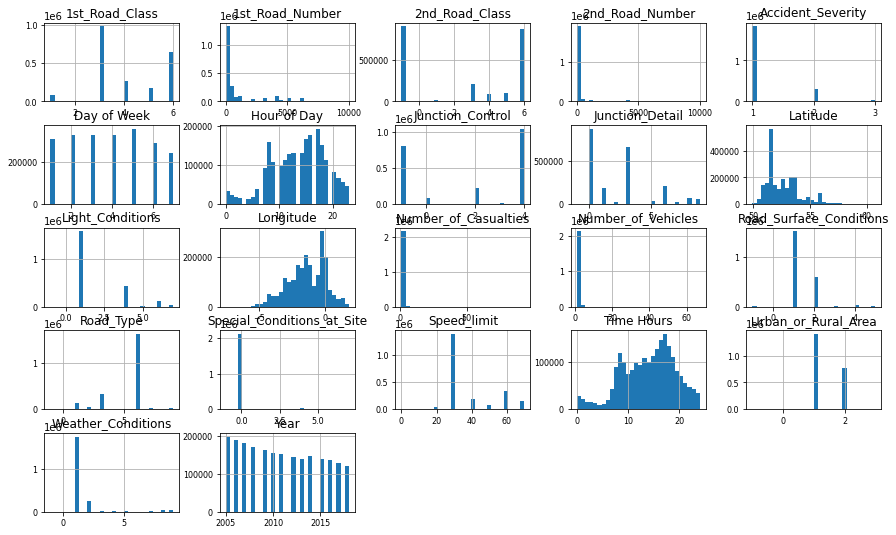

In [28]:
acc.hist(bins=30, xlabelsize=8, ylabelsize=8, figsize=(15,9));

At a first glance, we can already spot clusters for the field `Time Hours`, and a trend for the `Day of Week`, which is what we were expecting. Also, the majority of `Accident_Severity` are of type *Slight* (vs. *Serious* and *Fatal*). Location-wise (`Longitude`, `Latitude`), we see that the accidents are not uniformly distributed, which of course is obvious considering different population densities across the UK---we will analyze this further later on. The histogram for `Year` shows that the number of traffic accidents is decreasing over time, which is a pleasant discovery.

### Vehicles

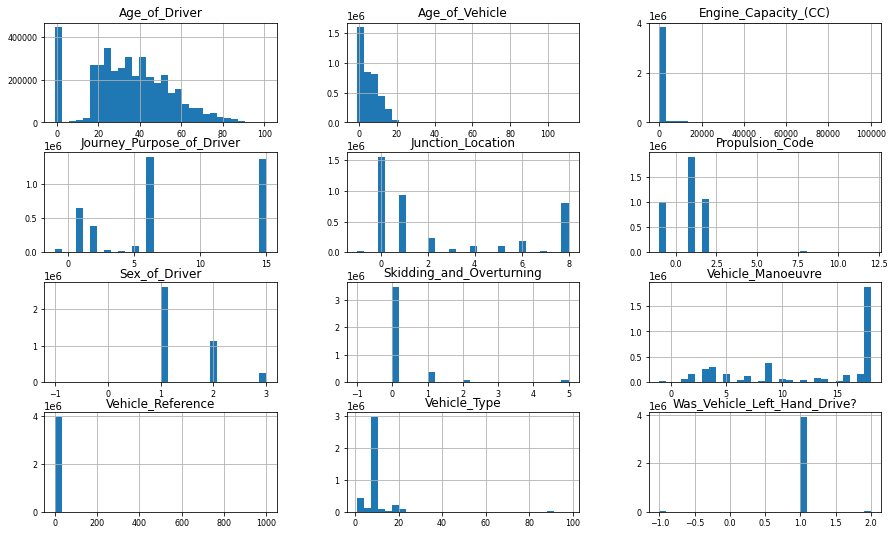

In [29]:
veh.hist(bins=30, xlabelsize=8, ylabelsize=8, figsize=(15,9));

Somewhat unsurprising, the most accidents are caused by 25 year old people, partially the reason why car insurance and rental companies have this age threshold for their pricing policy. The majority of the accidents are caused by men, which doesn't necessarily mean that they are worse drivers than women though, because they could just on average drive more often, or there are just more male car owners in general. In fact, according to a survey conducted in 2017 in the UK, 76% of the male participants, and 69% of the female participants own a motor vehicle.

### Casualties

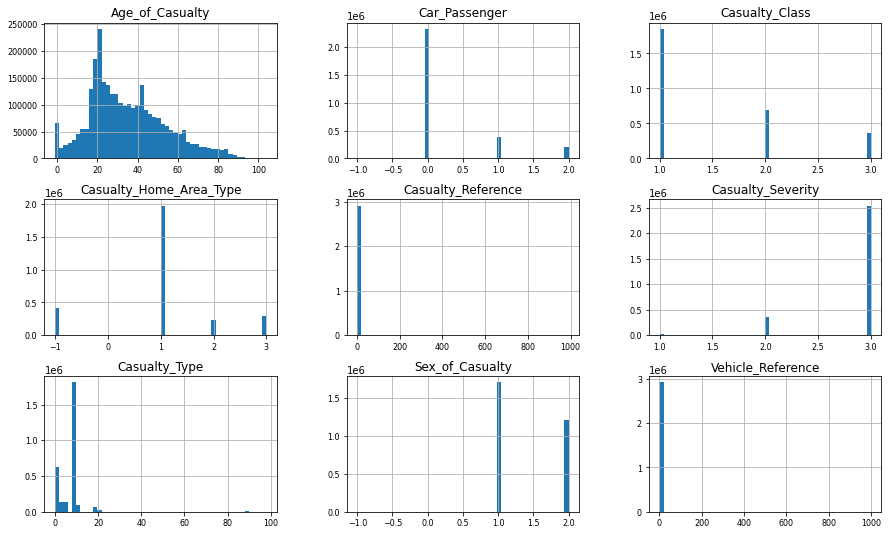

In [30]:
cas.hist(bins=50, xlabelsize=8, ylabelsize=8, figsize=(15,9));

The distribution of `Age_of_Casualty` paints a surprising picture. The peak is at around 20+ years old, which might be due to lack of experience and driving skills.

## Frequency & Severity Analyses

In this section, we conduct analyses considering the following guiding topics:
1. Analyze the distribution of accidents over time (i.e. accident frequency per year, weekday, hour of day)
2. Analyze how the severity of accidents depends on certain conditions (e.g. time, weather, roadtype, drivers' characteristics)

In the following, we provide a quick overview of all the analyses we apply in this part:
- Time trend analysis: development of accident frequency and severity over the years 2005-2018
- Severity & Frequency by hour of day
- Severity & Frequency by weekday
- Severity by weather condition
- Severity by road surface condition
- Severity by speed limits
- Severity by roadtype
- Severity by age group
- Severity by gender

Note that we apply the frequency analyses only on time variables. This is due to the reason that we do not reliably observe the base probabilities of variables like weather conditions, age groups or speed limits, which would be required to draw meaningful conclusions from a frequency analysis of such variables. However, since we only compare equally large time periods with each other (years with years, days with days, hours with hours) this is not a concern in frequency anlayses with time variables. Furthermore, to evaluate how the severity of accidents depend on certain variables, we calculate the share of total accidents occuring under the respective circumstances (e.g. speedlimit = 60mph, weather condition = snow, weekday = sunday) for each severity level (i.e. slight, serious or fatal). However, we have to bear in mind that for some variables/circumstances we analyze (e.g. speed limit = 10mph) the sample size (i.e. number of accidents) is not very large. Thus, we need to be cautious when interpreting those results because they clearly are subject to the so called "small sample bias" and are therefore probably not representative for the total population. However, since the sample sizes are large enough for most of our analyses, this appears to be a minor problem.

### Time trend analysis: Development of accident frequency & severity over the years 2005-2018

**Hypothesis #1**: Accidents get less frequent over the years, since the technology of intelligent accident prevention devices, programs used in vehicles, road safety measures are steadily improving and becoming more widespread.

**Hypothesis #2**: Fraction of fatal accidents decreases over the years, since roads are directed more efficiently, and security technology is improving.

,Total Accidents,Slight,Serious,Fatal
Year,,,,
2005,198610,0.859368,0.125976,0.014657
2006,189097,0.852642,0.131885,0.015474
2007,182049,0.851540,0.133557,0.014903
2008,170490,0.850730,0.135550,0.013719
2009,163492,0.852898,0.134520,0.012582
2010,154368,0.856395,0.132391,0.011213
2011,151441,0.849598,0.138536,0.011866
2012,145530,0.845152,0.143599,0.011249
2013,138612,0.846868,0.141546,0.011586


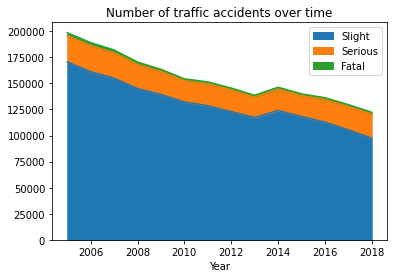

In [31]:
# copy variables of interest into a new dataframe
dat = acc[['Accident_Severity', 'Year']].dropna()

grp_year = dat.groupby(['Year'])['Accident_Severity'].count()
grp_year_s1 = dat[dat['Accident_Severity'] == 1].groupby(['Year'])['Accident_Severity'].count()
grp_year_s2 = dat[dat['Accident_Severity'] == 2].groupby(['Year'])['Accident_Severity'].count()
grp_year_s3 = dat[dat['Accident_Severity'] == 3].groupby(['Year'])['Accident_Severity'].count()

# grouped by severity
grp_pct0 = pd.concat([grp_year, grp_year_s1 / grp_year, grp_year_s2 / grp_year, grp_year_s3 / grp_year], axis=1)
grp_pct0.columns = ['Total Accidents', 'Slight', 'Serious', 'Fatal']

# plot overall time trend
grp_pct1 = pd.concat([grp_year, grp_year_s1, grp_year_s2, grp_year_s3], axis=1)
grp_pct1.columns = ['Total Accidents', 'Slight', 'Serious', 'Fatal']
grp_pct1[['Slight', 'Serious', 'Fatal']].plot.area(title='Number of traffic accidents over time');

# print table
grp_pct0

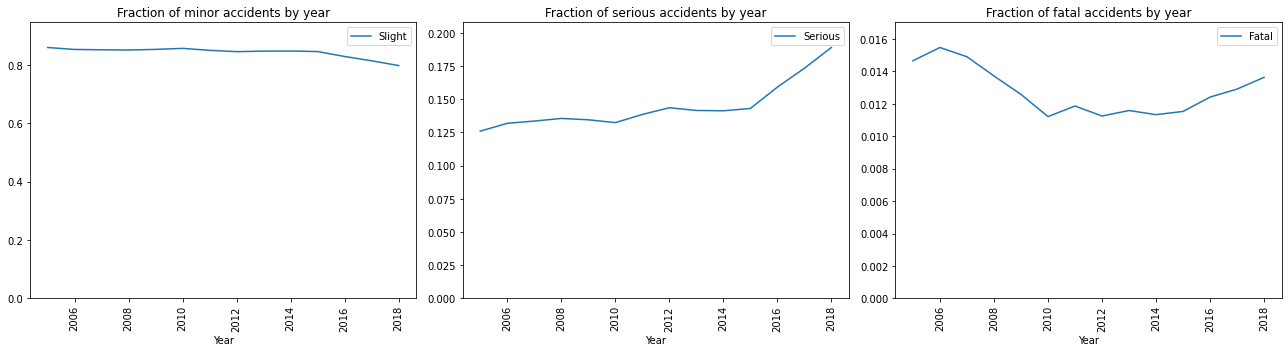

In [32]:
# plots
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(18,5))
grp_pct0[['Slight']].plot.line(ax=ax1, rot=90, title='Fraction of minor accidents by year', ylim=(0, 1.1*grp_pct0['Slight'].max()));
grp_pct0[['Serious']].plot.line(ax=ax2, rot=90, title='Fraction of serious accidents by year', ylim=(0, 1.1*grp_pct0['Serious'].max()));
grp_pct0[['Fatal']].plot.line(ax=ax3, rot=90, title='Fraction of fatal accidents by year', ylim=(0, 1.1*grp_pct0['Fatal'].max()));
plt.tight_layout()

By looking at the development of accident frequency over time, we observe that the number of yearly accidents reveals a decreasing trend. This observation supports our first hypothesis. Furthermore, we observe that the fraction of fatal accidents decreases from 2005 to 2011, then remains on a more or less stable level until 2015 and then starts to slightly increase again. This pattern contradicts the one we hypothesize with Hypothesis #2 (see above). A possible explaination could be that in addition to the traditional sources that can divert one’s attention from the road, such as eating, speaking to passengers or chatting on the cellphone, new dangers are also emerging as people become more reliant on technology. Distracted driving from new sources (think of checking Facebook, Instagram, Twitter or Snapchat on your phone) have also been blamed for part of this increase. In conclusion, the number of yearly accidents has decreased (supporting Hypothesis #1), while the relative proportions regarding accidents severity have stayed more or less constant, with "serious" accidents showing a slight increasing trend (contradicting Hypothesis #2).

### Severity & Frequency by hour of day

**Hypothesis #3**: Accidents are most frequent during the rush hour (i.e. at 8 am and 5 pm).

**Hypothesis #4**: Accidents occuring during the rush hour are in turn the least severe ones due to the heavy traffic which impedes riders from speeding and aggressive driving.

**Hypothesis #5**: Accidents are less frequent by night.

**Hypothesis #6**: Accidents occuring by night are in turn more severe than those occuring during the daytime, because the attainable speeds are higher.

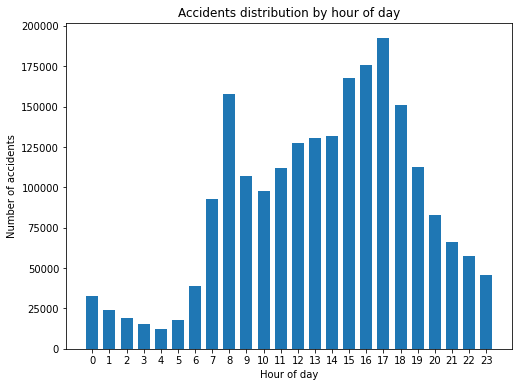

In [33]:
fig, ax = plt.subplots(figsize=(8,6))
ax.hist(x=acc['Hour of Day'], bins=range(0, 25, 1), rwidth=0.7)
ax.set_xticks(np.arange(0.5, 24, 1))
ax.set_xticklabels(range(0, 24))
plt.xlabel('Hour of day')
plt.ylabel('Number of accidents')
plt.title('Accidents distribution by hour of day');

We observe a bimodal distribution, hence two distinct peaks: the first one at the 9th hour of a day (i.e. between 8:00 and 9:00) and the second one at the 18th hour of a day (i.e. between 17:00 and 18:00). This pattern provides evidence for Hypothesis #3, since it indicates that most accidents indeed occur during the rush hour. During the rush hour, there are clearly more vehicles on the road, which consequently leads to more accidents. Furthermore, we observe that during the night considerably fewer accidents occur than during the day, which provides support for Hypothesis #5. This is also intuitively explainable, since there is obviously less traffic by night. Overall, we can conclude that the accident frequency depicts an oscillating trend, with the lowest point between 4:00 and 5:00 in the morning and the peak between 17:00 and 18:00 (if we flatten out the rush hour peak in the morning), strongly correlating to the actual traffic volume.

,Total Accidents,Slight,Serious,Fatal
Hour of Day,,,,
0,32890,0.776953,0.192794,0.030252
1,23994,0.768650,0.199342,0.032008
2,19072,0.756502,0.208001,0.035497
3,15469,0.757709,0.203827,0.038464
4,12192,0.759843,0.201280,0.038878
5,18039,0.779034,0.188370,0.032596
6,39038,0.815154,0.165224,0.019622
7,92484,0.849671,0.138619,0.011710
8,157917,0.882198,0.111381,0.006421


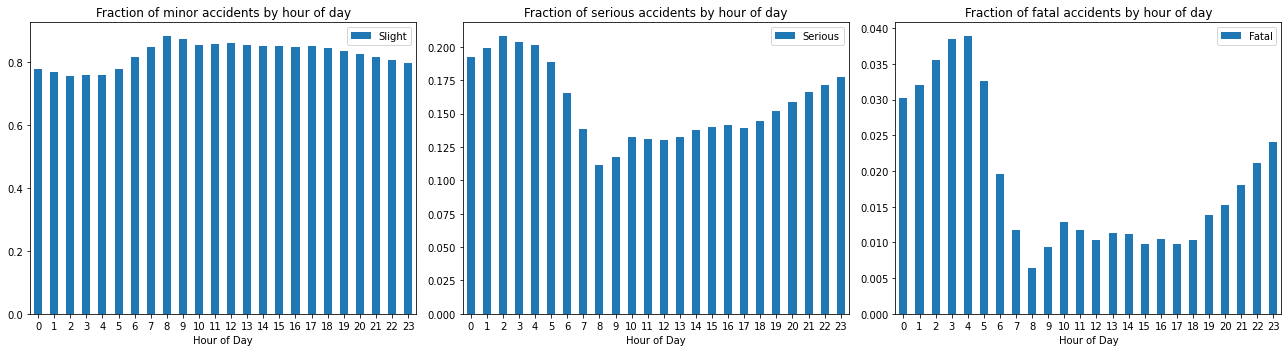

In [34]:
# copy variables of interest into a new dataframe
dat = acc[['Accident_Severity', 'Hour of Day']].dropna()

grp_year = dat.groupby(['Hour of Day'])['Accident_Severity'].count()
grp_year1 = dat[dat['Accident_Severity'] == 1].groupby(['Hour of Day'])['Accident_Severity'].count()
grp_year2 = dat[dat['Accident_Severity'] == 2].groupby(['Hour of Day'])['Accident_Severity'].count()
grp_year3 = dat[dat['Accident_Severity'] == 3].groupby(['Hour of Day'])['Accident_Severity'].count()

# create dataframe
grp_pct1 = pd.concat([grp_year, grp_year1 / grp_year, grp_year2 / grp_year, grp_year3 / grp_year], axis=1)
grp_pct1.columns = ['Total Accidents', 'Slight', 'Serious', 'Fatal']

# plots
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(18,5))
grp_pct1[['Slight']].plot.bar(ax=ax1, rot=0, title='Fraction of minor accidents by hour of day');
grp_pct1[['Serious']].plot.bar(ax=ax2, rot=0, title='Fraction of serious accidents by hour of day');
grp_pct1[['Fatal']].plot.bar(ax=ax3, rot=0, title='Fraction of fatal accidents by hour of day');
plt.tight_layout()

# print table
grp_pct1

Looking at the barplots, we see that accidents by night have a much higher portion of serious and fatal accidents than accidents occuring during the day. Intuitively, this makes sense due to several reasons:

- The probability of icy road surfaces and cold weather conditions is higher by night due to lack of sunlight.
- By night, bad light conditions makes it harder to drive safely and see obstacles and danger far ahead.
- The low traffic allows for speeding and risky driving.
- The protion of drivers which drive under the influence of alcohol and other impairing substances is most likely higher by night.

All these insights provide quite strong support for Hypothesis #6.

Moreover, we observe that the hour of day with the smallest fraction of serious and fatal accidents is exactly the one during the morning rush hour. The evening rush hour between 5 pm and 6 pm also shows a rather small fraction of fatal accidents. Hence, we can conclude that accidents occuring during the rush hour indeed tend to be less severe than those happening during other hours of the day or by night, which provides support for Hypothesis #4.

### Severity & Frequency by weekday

**Hypothesis #7**: Accidents are less frequent on the weekends.

**Hypothesis #8**: Accidents are in turn more severe on weekends.

**Hypothesis #9**: The effect of accidents being more severe on weekends is stronger for motorcycles than for other vehicles.

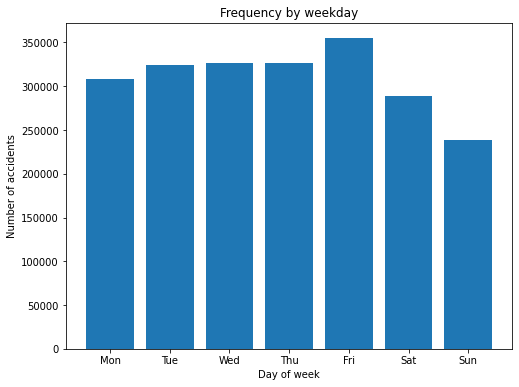

In [35]:
# count the number of accidents on each weekday
acc_weekday = acc.groupby(['Day of Week'])['Accident_Index'].count()

# plot
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(acc_weekday.index, height=acc_weekday)
ax.set_xticks(np.arange(1, 8))
ax.set_xticklabels(weekdays_abbr)
plt.xlabel('Day of week')
plt.ylabel('Number of accidents')
plt.title('Frequency by weekday');

We observe that on weekends, considerably less accidents occur, which provides support for Hypothesis #7. This is intuitive, since on weekends, there is generally less traffic on the roads than during the week. Furthermore, we can see that most accidents happen on Fridays. A possible explanation for this pattern is that people are tired because of the work week, and probably tend to drive more aggressively with the weekend in sight. However, we think that one could reasonably argue that those accidents which happen on weekends in turn are more severe (i.e. Hypothesis #8). Furthermore, we hypothesize that weekend accidents are even more severe for motorcyclists than for other vehicles (i.e. Hypothesis #9). We analyse these hypotheses in the following.

#### Severity by weekday: all vehicles

,Total Accidents,Slight,Serious,Fatal
Monday,307965,0.852516,0.135704,0.011781
Tuesday,324020,0.853830,0.135149,0.011021
Wednesday,326764,0.854240,0.134843,0.010916
Thursday,326642,0.851593,0.137006,0.011401
Friday,354934,0.848439,0.139513,0.012047
Saturday,289013,0.827129,0.156277,0.016594
Sunday,238965,0.813056,0.168276,0.018668


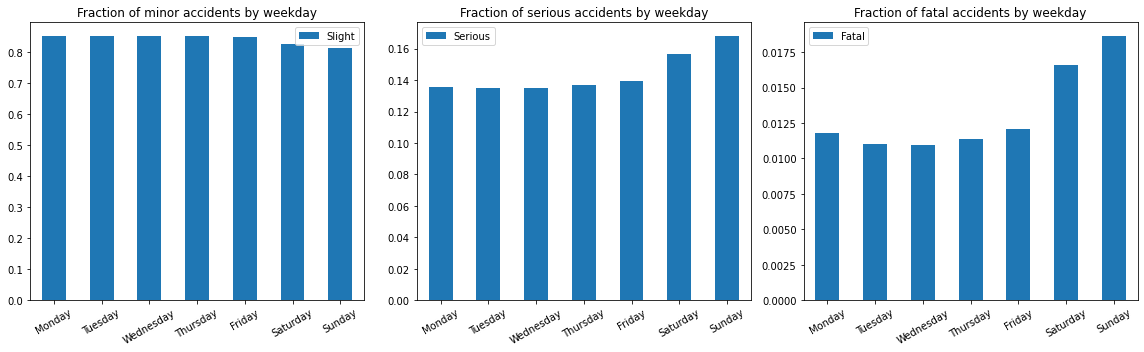

In [36]:
# copy the variables of interest into a new dataframe
dat = acc[['Accident_Severity', 'Day of Week']].dropna()

# calculate the fraction of each severity level per weekday
dat_count = dat.groupby(['Day of Week'])['Accident_Severity'].count()
dat_s1 = dat[dat['Accident_Severity'] == 1].groupby(['Day of Week'])['Accident_Severity'].count()
dat_s2 = dat[dat['Accident_Severity'] == 2].groupby(['Day of Week'])['Accident_Severity'].count()
dat_s3 = dat[dat['Accident_Severity'] == 3].groupby(['Day of Week'])['Accident_Severity'].count()

# create dataframe
grp_pct2 = pd.concat([dat_count, dat_s1 / dat_count, dat_s2 / dat_count, dat_s3 / dat_count], axis=1)
grp_pct2.columns = ['Total Accidents', 'Slight', 'Serious', 'Fatal']
grp_pct2.index = weekdays

# plots
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(16,5))
grp_pct2[['Slight']].plot.bar(ax=ax1, rot=30, title='Fraction of minor accidents by weekday');
grp_pct2[['Serious']].plot.bar(ax=ax2, rot=30, title='Fraction of serious accidents by weekday');
grp_pct2[['Fatal']].plot.bar(ax=ax3, rot=30, title='Fraction of fatal accidents by weekday');
plt.tight_layout()

# print table
grp_pct2

We observe that on weekends, the portions of serious and fatal accidents are indeed higher than during the week. This pattern supports Hypothesis #8. Comparing to more frequent, but less severe accidents happend during weekdays, the higher portions of more severe accidents could be resulting from two reasons:
- More car drivers are related to driving under the influence of alcohol on weekends, which is a key reason so many crash-related deaths occur.
- Speeding is another factor that people are inclined to drive faster on holiday since they are usually more relaxed, careless and fun-driven (pun intended) on weekends.

#### Severity by weekday: only motorbikes

,Total Accidents,Slight,Serious,Fatal
Monday,40030,0.731676,0.251062,0.017262
Tuesday,43707,0.737433,0.246048,0.016519
Wednesday,44110,0.735434,0.248152,0.016414
Thursday,44357,0.734923,0.248191,0.016886
Friday,46872,0.726468,0.255462,0.018070
Saturday,37626,0.676580,0.295726,0.027694
Sunday,34954,0.635750,0.328374,0.035876


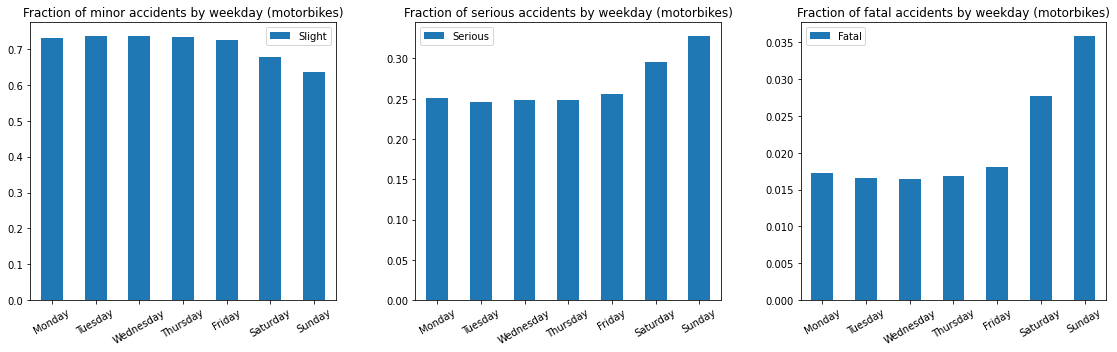

In [37]:
# copy the observations of interest into a new data frame (only motorbikes)
acc_idxs = veh[veh['Vehicle_Type'].isin([2,3,4,5,23,97])]['Accident_Index'].unique()
dat = acc[acc['Accident_Index'].isin(acc_idxs)]

# copy the variables of interest into a new dataframe
dat = dat[['Accident_Severity', 'Day of Week']].dropna()

# calculate the fraction of each severity level per weekday
dat_count = dat.groupby(['Day of Week'])['Accident_Severity'].count()
dat_s1 = dat[dat['Accident_Severity'] == 1].groupby(['Day of Week'])['Accident_Severity'].count()
dat_s2 = dat[dat['Accident_Severity'] == 2].groupby(['Day of Week'])['Accident_Severity'].count()
dat_s3 = dat[dat['Accident_Severity'] == 3].groupby(['Day of Week'])['Accident_Severity'].count()

# create dataframe
grp_pct3 = pd.concat([dat_count, dat_s1 / dat_count, dat_s2 / dat_count, dat_s3 / dat_count], axis=1)
grp_pct3.columns = ['Total Accidents', 'Slight', 'Serious', 'Fatal']
grp_pct3.index = weekdays

# plots
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(16,5))
grp_pct3[['Slight']].plot.bar(ax=ax1, rot=30, title='Fraction of minor accidents by weekday (motorbikes)');
grp_pct3[['Serious']].plot.bar(ax=ax2, rot=30, title='Fraction of serious accidents by weekday (motorbikes)');
grp_pct3[['Fatal']].plot.bar(ax=ax3, rot=30, title='Fraction of fatal accidents by weekday (motorbikes)');
plt.tight_layout()

# print table
grp_pct3

Comparing the barplots, we see that the fraction of fatal accidents for motorbikes by weekday is higher than for all other vehicle types, hence providing support for Hypothesis #9.
- Traffic is usually less heavy on weekends, so motorbike drivers can drive at higher speeds which increases the likelihood of more severe accidents.
- The main purpose of driving a motorbike on weekdays is commuting, while on weekends the main reason is rather for touring or fun, and also taking roads and trips which are more interesting and challenging, hence more dangerous.
- Driving a motorbike itself is less protective compared to driving a car. The driver of a motorbike is directly exposed to other vehicles, with little or no protection like airbags or crumple zones.

### Severity by weather condition

**Hypothesis #10**: Bad weather conditions lead to more sever accidents, e.g. rain, snow, fogg or heavy winds.

,Total Accidents,Slight,Serious,Fatal
Weather_Conditions,,,,
Fine,1765039,0.839798,0.146785,0.013416
Fog,11507,0.826280,0.151212,0.022508
Rain,281523,0.859170,0.129709,0.011122
Snow,17338,0.884416,0.107567,0.008017


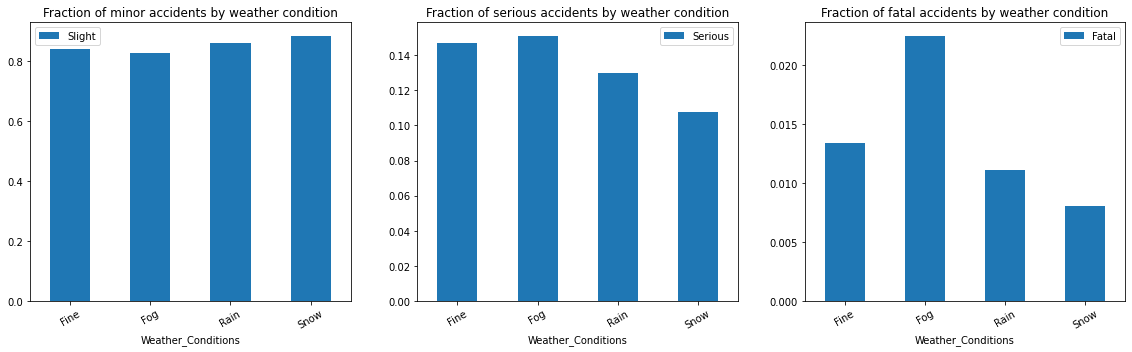

In [38]:
# copy the variables of interest into a new dataframe
dat = acc[['Accident_Severity', 'Weather_Conditions']].dropna()

# select only accidents where the weather condition is known
dat = dat[dat['Weather_Conditions'].isin([1,2,3,4,5,6,7])]

# create a variable to indicate if there were heavy winds
dat['Wind'] = dat['Weather_Conditions'].isin([4,5,6]).astype(int)
dat['Wind'] = dat['Wind'].astype(str)
dat.loc[dat['Wind'].isin(['1']), 'Wind'] = 'Heavy winds'
dat.loc[dat['Wind'].isin(['0']), 'Wind'] = 'No heavy winds'

# reshape the Weather_Conditions variable
dat['Weather_Conditions'] = dat['Weather_Conditions'].astype(str)
dat.loc[dat['Weather_Conditions'].isin(['1','4']), 'Weather_Conditions'] = 'Fine'
dat.loc[dat['Weather_Conditions'].isin(['2','5']), 'Weather_Conditions'] = 'Rain'
dat.loc[dat['Weather_Conditions'].isin(['3','6']), 'Weather_Conditions'] = 'Snow'
dat.loc[dat['Weather_Conditions'].isin(['7']), 'Weather_Conditions'] = 'Fog'

# calculate the fraction of each severity level per weather condition
dat_count = dat.groupby(['Weather_Conditions'])['Accident_Severity'].count()
dat_s1 = dat[dat['Accident_Severity'] == 1].groupby(['Weather_Conditions'])['Accident_Severity'].count()
dat_s2 = dat[dat['Accident_Severity'] == 2].groupby(['Weather_Conditions'])['Accident_Severity'].count()
dat_s3 = dat[dat['Accident_Severity'] == 3].groupby(['Weather_Conditions'])['Accident_Severity'].count()

# create dataframe
grp_pct4 = pd.concat([dat_count, dat_s1 / dat_count, dat_s2 / dat_count, dat_s3 / dat_count], axis=1)
grp_pct4.columns = ['Total Accidents', 'Slight', 'Serious', 'Fatal']

# plots
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(16,5))
grp_pct4[['Slight']].plot.bar(ax=ax1, rot=30, title='Fraction of minor accidents by weather condition');
grp_pct4[['Serious']].plot.bar(ax=ax2, rot=30, title='Fraction of serious accidents by weather condition');
grp_pct4[['Fatal']].plot.bar(ax=ax3, rot=30, title='Fraction of fatal accidents by weather condition');
plt.tight_layout()

# print table
grp_pct4

,Total Accidents,Slight,Serious,Fatal
Wind,,,,
Heavy winds,59425,0.837745,0.146184,0.016071
No heavy winds,2015982,0.842871,0.144106,0.013023


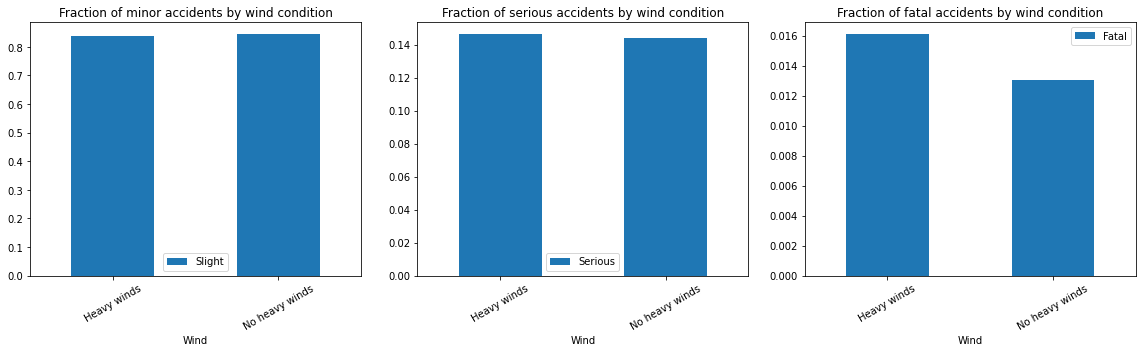

In [39]:
# calculate the fraction of each severity level per wind condition
dat_count = dat.groupby(['Wind'])['Accident_Severity'].count()
dat_s1 = dat[dat['Accident_Severity'] == 1].groupby(['Wind'])['Accident_Severity'].count()
dat_s2 = dat[dat['Accident_Severity'] == 2].groupby(['Wind'])['Accident_Severity'].count()
dat_s3 = dat[dat['Accident_Severity'] == 3].groupby(['Wind'])['Accident_Severity'].count()

# create dataframe
grp_pct5 = pd.concat([dat_count, dat_s1 / dat_count, dat_s2 / dat_count, dat_s3 / dat_count], axis=1)
grp_pct5.columns = ['Total Accidents', 'Slight', 'Serious', 'Fatal']

# plots
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(16,5))
grp_pct5[['Slight']].plot.bar(ax=ax1, rot=30, title='Fraction of minor accidents by wind condition');
grp_pct5[['Serious']].plot.bar(ax=ax2, rot=30, title='Fraction of serious accidents by wind condition');
grp_pct5[['Fatal']].plot.bar(ax=ax3, rot=30, title='Fraction of fatal accidents by wind condition');
plt.tight_layout()

# print table
grp_pct5

We observe that on windy and/or foggy days, there are more serious and fatal accidents, which supports Hypothesis #10. However, contrary to our intuition, the ratio of serious and fatal accidents on snowy and rainy days is lower than on days with good weather conditions. Several explanations are suggested by us:

- Bad sight on foggy days and strong disturbance on days with heavy winds contribute to more severe accidents.
- People tend to drive more carefully when it is raining or snowing, taking less risks.

Furthermore, we observe slightly more minor accidents at bad weather conditions (i.e. snow and rain) compared to good conditions, which is what we intuitively expected.

### Severity by road surface condition

**Hypothesis #11**: Bad road surface conditions lead to more severe accidents, e.g. wet, snow, frost or flood.

,Total Accidents,Slight,Serious,Fatal
Dry,1507605,0.842222,0.145238,0.012540
Wet or damp,596417,0.846713,0.139029,0.014258
Snow,13256,0.887900,0.104783,0.007317
Frost or ice,41720,0.868145,0.121429,0.010427
Flood over 3cm deep,2979,0.838536,0.141323,0.020141


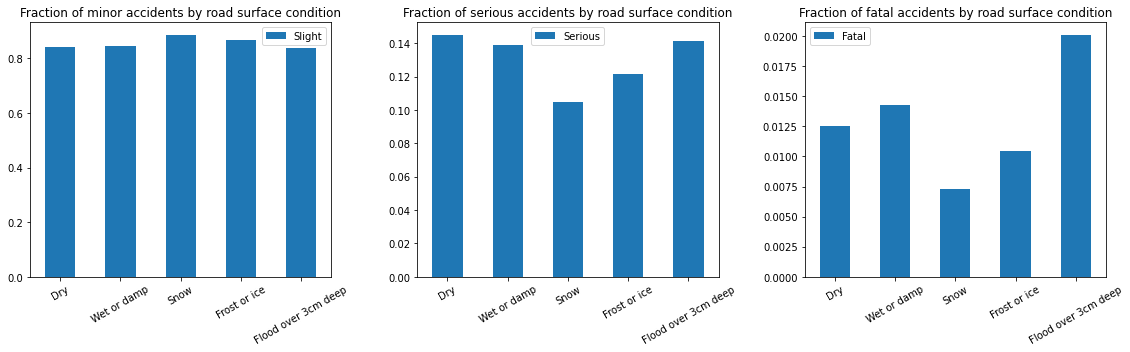

In [40]:
# copy the observations of interest into a new dataframe
dat = acc[acc['Road_Surface_Conditions'] != -1]
dat = dat[['Accident_Severity', 'Road_Surface_Conditions']].dropna()

# calculate the fraction of each severity level per road surface condition
dat_count = dat.groupby(['Road_Surface_Conditions'])['Accident_Severity'].count()
dat_s1 = dat[dat['Accident_Severity'] == 1].groupby(['Road_Surface_Conditions'])['Accident_Severity'].count()
dat_s2 = dat[dat['Accident_Severity'] == 2].groupby(['Road_Surface_Conditions'])['Accident_Severity'].count()
dat_s3 = dat[dat['Accident_Severity'] == 3].groupby(['Road_Surface_Conditions'])['Accident_Severity'].count()

# create dataframe
grp_pct6 = pd.concat([dat_count, dat_s1 / dat_count, dat_s2 / dat_count, dat_s3 / dat_count], axis=1)
grp_pct6.columns = ['Total Accidents', 'Slight', 'Serious', 'Fatal']
grp_pct6.index = ['Dry', 'Wet or damp', 'Snow', 'Frost or ice', 'Flood over 3cm deep']

# plots
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(16,5))
grp_pct6[['Slight']].plot.bar(ax=ax1, rot=30, title='Fraction of minor accidents by road surface condition');
grp_pct6[['Serious']].plot.bar(ax=ax2, rot=30, title='Fraction of serious accidents by road surface condition');
grp_pct6[['Fatal']].plot.bar(ax=ax3, rot=30, title='Fraction of fatal accidents by road surface condition');
plt.tight_layout()

# print table
grp_pct6

Similarly to the patterns observed by looking at severity and weather conditions, the results we got here are only partially consistent with our Hypothesis #11. We observe that only on wet or damp roads, and roads with flood over 3cm deep, have higher proportion of serious and fatal accidents than on dry roads. Sereval explanations are suggested by us:

- People don't assess wet or damp roads as dangerous driving conditions and pay less or equal attention as driving at good road conditions, while these conditions indeed cause more technical issues (aquaplaning, slip, etc.), and obviously so do roads with flood over 3cm deep.
- On the one hand, snow and frost make driving more dangerous, by reducing tire adherence and impairing visibility ,but on the other hand, experienced drivers typically drive more slowly and carefully in snowy or frosty weather, or postpone unnecessary travel altogether.

### Severity by speed limits

**Hypothesis #12**: Accidents are more severe on roads with higher speed limits.

,Total Accidents,Slight,Serious,Fatal
Speed_limit,,,,
10.0,17,0.705882,0.117647,0.176471
15.0,13,0.923077,0.076923,0.000000
20.0,37026,0.847648,0.146870,0.005483
30.0,1149588,0.867125,0.125752,0.007123
40.0,160847,0.846581,0.138293,0.015126
50.0,70114,0.826725,0.151411,0.021864
60.0,312855,0.777037,0.191299,0.031663
70.0,151527,0.852871,0.124380,0.022748


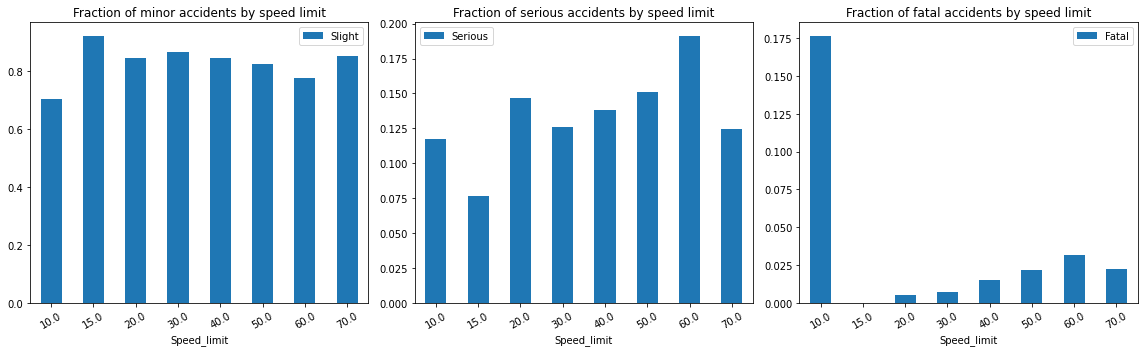

In [41]:
# copy the observations of interest into a new data frame (note: we omit accidents where non-motor vehicles were involved)
rm_acc_idxs = veh.loc[veh['Vehicle_Type'].isin([-1,1,16,22,90]), 'Accident_Index'].unique()
dat = acc.loc[~acc['Accident_Index'].isin(rm_acc_idxs)]
dat = dat[['Accident_Severity', 'Speed_limit']].dropna()

# calculate the fraction of each severity level per speed limit
dat_count = dat.groupby(['Speed_limit'])['Accident_Severity'].count()
dat_s1 = dat[dat['Accident_Severity'] == 1].groupby(['Speed_limit'])['Accident_Severity'].count()
dat_s2 = dat[dat['Accident_Severity'] == 2].groupby(['Speed_limit'])['Accident_Severity'].count()
dat_s3 = dat[dat['Accident_Severity'] == 3].groupby(['Speed_limit'])['Accident_Severity'].count()

# create dataframe
grp_pct7 = pd.concat([dat_count, dat_s1 / dat_count, dat_s2 / dat_count, dat_s3 / dat_count], axis=1)
grp_pct7 = grp_pct7.fillna(0)
grp_pct7.columns = ['Total Accidents', 'Slight', 'Serious', 'Fatal']

# plots
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(16,5))
grp_pct7[['Slight']].plot.bar(ax=ax1, rot=30, title='Fraction of minor accidents by speed limit');
grp_pct7[['Serious']].plot.bar(ax=ax2, rot=30, title='Fraction of serious accidents by speed limit');
grp_pct7[['Fatal']].plot.bar(ax=ax3, rot=30, title='Fraction of fatal accidents by speed limit');
plt.tight_layout()

# print table
grp_pct7

We observe that the fraction of severe accidents (serious, fatal) increases with the speed limit until 60 mph (except for speed limit at 10 mph and 15 mph due to the apparant small sample bias). This supports our Hypothesis #12---higher speeds increase the kinetic energy, hence potential impacts pose a higher threat to the vehicle passengers. The drop in fraction of severe accidents for 70 mph is not obvious to us, we speculate that more experienced drivers tend to use those roads. Further investigation, e.g. by vehicle type and age-group would be required to analyze this finding.

### Severity by roadtypes

**Hypothesis #13**: Accidents are more severe on motorways than on other roads.

,Total Accidents,Slight,Serious,Fatal
Motorways (A/M),88032,0.884633,0.098998,0.016369
Trunk routes (A),979694,0.841738,0.142241,0.016020
Distributor roads (B),272109,0.829774,0.156107,0.014119
Minor roads (C),181896,0.846638,0.141449,0.011913
Unclassified roads,646572,0.849867,0.142778,0.007356


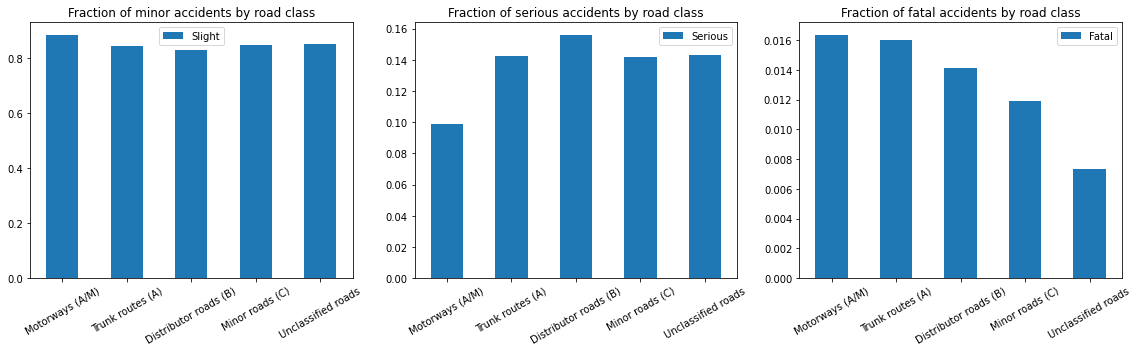

In [42]:
# copy the variables of interest into a new dataframe
dat = acc[['Accident_Severity', '1st_Road_Class']].dropna()
dat['Road_Class'] = dat['1st_Road_Class']

# reshape the Road_Class variable such that all motorways (Motorways & A(M) roads) are combined into 1 road class
dat[dat['Road_Class'] == 2] = 1

# calculate the fraction of each severity level per road class
dat_count = dat.groupby(['Road_Class'])['Accident_Severity'].count()
dat_s1 = dat[dat['Accident_Severity'] == 1].groupby(['Road_Class'])['Accident_Severity'].count()
dat_s2 = dat[dat['Accident_Severity'] == 2].groupby(['Road_Class'])['Accident_Severity'].count()
dat_s3 = dat[dat['Accident_Severity'] == 3].groupby(['Road_Class'])['Accident_Severity'].count()

# create dataframe
grp_pct8 = pd.concat([dat_count, dat_s1 / dat_count, dat_s2 / dat_count, dat_s3 / dat_count], axis=1)
grp_pct8.columns = ['Total Accidents', 'Slight', 'Serious', 'Fatal']
grp_pct8.index = ['Motorways (A/M)', 'Trunk routes (A)', 'Distributor roads (B)', 'Minor roads (C)', 'Unclassified roads']

# plots
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(16,5))
grp_pct8[['Slight']].plot.bar(ax=ax1, rot=30, title='Fraction of minor accidents by road class');
grp_pct8[['Serious']].plot.bar(ax=ax2, rot=30, title='Fraction of serious accidents by road class');
grp_pct8[['Fatal']].plot.bar(ax=ax3, rot=30, title='Fraction of fatal accidents by road class');
plt.tight_layout()

# print table
grp_pct8

We observe that while accidents occurring on motorways have the highest fatality rate, the accidents occuring on trunk routes have almost the same fatality rate, and an even higher portion of serious accidents. In addition, distributor roads also have relatively high rate of fatal and serious accidents compared to the other two types of roads. This is only partially consistant with our Hypothesis #13. We explain this finding by the following reasoning:
- Trunk roads are the main traffic routes, which means it has the heavist traffic and results in considerably high rates of serious and fatal accidents.
- Most of the cars on distributor roads are the trucks carrying heavy goods, also resulting relatively high rates of serious and fatal accidents.
- Inexperienced drivers avoid driving on motorways.

### Severity by age group

**Hypothesis #14**: Accidents caused by young drivers (i.e. age <= 25), and old drivers (i.e. age > 75), are more severe than accidents caused by drivers between those age thresholds.

In order to analyze the severity of **car accidents** by age group, we need to form age bins, and identify who caused the accident. Though, with multiple vehicles involved in an accident, it is unclear who and/or what caused the accident, especially using this dataset. For this reason, we only look at single-vehicle accidents (Selbstunfälle), which allows us to clearly identify the perpetrator of an accident and draw stronger conclusions.

Finally, we need to join the `Accidents` table with the `Vehicles` table.

In [43]:
# filter out vehicles with more than one vehicle/driver involved
rm_veh_idxs = veh[['Accident_Index']].duplicated(keep=False)
dat = veh[~rm_veh_idxs].copy()
print(f'Filtered out {rm_veh_idxs.sum()} vehicles because of multiple drivers involved')

# filter out vehicles with unknown driver age
rm_veh_idxs = dat['Age_of_Driver'] < 16 | dat['Age_of_Driver'].isna()
dat = dat[~rm_veh_idxs]
print(f'Filtered out {rm_veh_idxs.sum()} vehicles because of missing/invalid driver age')

# filter out vehicles with unknown driver
rm_veh_idxs = ~dat['Sex_of_Driver'].isin([1,2])
dat = dat[~rm_veh_idxs]
print(f'Filtered out {rm_veh_idxs.sum()} vehicles because of unknown driver sex')

# only look at car accidents
rm_veh_idxs = dat['Vehicle_Type'] != 9
dat = dat[~rm_veh_idxs]
print(f'Filtered out {rm_veh_idxs.sum()} vehicles because of vehicle is not a car')

print(f'{dat.shape[0]} vehicles left for analysis')

# map age to age bins
agebins = ['<=25','26-35','36-45','46-60','61-75','76+']

def age_bin(age):
  if age <= 25:
    return 0
  elif age <= 35:
    return 1
  elif age <= 45:
    return 2
  elif age <= 60:
    return 3
  elif age <= 75:
    return 4
  else:
    return 5
dat['Age Bin'] = dat['Age_of_Driver'].apply(age_bin)

# join Accidents with filtered Vehicles
dat = pd.merge(acc, dat, on='Accident_Index', how='inner')
dat.head()

Filtered out 3324152 vehicles because of multiple drivers involved
Filtered out 74776 vehicles because of missing/invalid driver age
Filtered out 3375 vehicles because of unknown driver sex
Filtered out 164676 vehicles because of vehicle is not a car
410139 vehicles left for analysis


,Accident_Index,Longitude,Latitude,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Time,1st_Road_Class,1st_Road_Number,...,Junction_Location,Skidding_and_Overturning,Was_Vehicle_Left_Hand_Drive?,Journey_Purpose_of_Driver,Sex_of_Driver,Age_of_Driver,Engine_Capacity_(CC),Propulsion_Code,Age_of_Vehicle,Age Bin
0,200501BS00001,-0.191170,51.489096,2,1,1,2005-01-04,17:42,3,3218,...,0,0,1,15,2,74,-1,-1,-1,4
1,200501BS00004,-0.173862,51.482442,1,1,1,2005-01-07,10:35,3,3220,...,0,0,1,15,2,49,1769,1,4,3
2,200501BS00009,-0.187623,51.502260,1,1,2,2005-01-14,17:35,3,315,...,0,0,1,15,1,68,5343,1,16,4
3,200501BS00012,-0.182872,51.494902,1,1,1,2005-01-16,00:42,3,4,...,8,0,1,15,1,34,1988,1,6,1
4,200501BS00015,-0.192366,51.491632,1,1,1,2005-01-11,12:55,6,0,...,3,0,1,15,2,47,1360,1,2,3


In [44]:
# quickly evaluate whether we have enough data for each year
dat.groupby('Year')['Accident_Index'].count()

Year
2005    39390
2006    37620
2007    35874
2008    33908
2009    32534
2010    29934
2011    28633
2012    27450
2013    25871
2014    26007
2015    24830
2016    23844
2017    22983
2018    21261
Name: Accident_Index, dtype: int64

The histogram reveals that, almost linearly, the amount of single-vehicle accidents decreases by increasing age and experience.

,Total Accidents,Slight,Serious,Fatal
<=25,129311,0.791503,0.185978,0.022519
26-35,88971,0.789875,0.191208,0.018916
36-45,70647,0.792730,0.190765,0.016505
46-60,69890,0.784333,0.198498,0.017170
61-75,35261,0.774822,0.206914,0.018264
76+,16059,0.748365,0.223675,0.027959


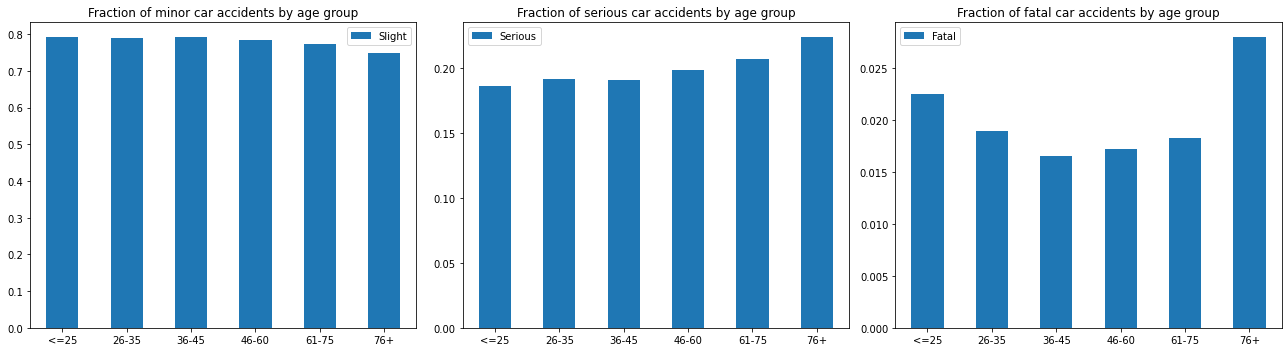

In [45]:
# copy the variables of interest into a new dataframe
dat2 = dat[['Accident_Severity', 'Age Bin']].dropna()

# calculate the fraction of each severity level for different age group
dat_count = dat2.groupby(['Age Bin'])['Accident_Severity'].count()
dat_s1 = dat2[dat2['Accident_Severity'] == 1].groupby(['Age Bin'])['Accident_Severity'].count()
dat_s2 = dat2[dat2['Accident_Severity'] == 2].groupby(['Age Bin'])['Accident_Severity'].count()
dat_s3 = dat2[dat2['Accident_Severity'] == 3].groupby(['Age Bin'])['Accident_Severity'].count()

# create dataframe
grp_pct9 = pd.concat([dat_count, dat_s1 / dat_count, dat_s2 / dat_count, dat_s3 / dat_count], axis=1)
grp_pct9.columns = ['Total Accidents', 'Slight', 'Serious', 'Fatal']
grp_pct9.index = agebins

# plots
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(18,5))
grp_pct9[['Slight']].plot.bar(ax=ax1, rot=0, title='Fraction of minor car accidents by age group');
grp_pct9[['Serious']].plot.bar(ax=ax2, rot=0, title='Fraction of serious car accidents by age group');
grp_pct9[['Fatal']].plot.bar(ax=ax3, rot=0, title='Fraction of fatal car accidents by age group');
plt.tight_layout()

# print table
grp_pct9

The pattern observed in the plot for *fatal* accidents exactly confirms Hypothesis #14---young and old drivers cause more fatal accidents than drivers aged between 26 and 75 years. For serious accidents, the fraction increases with increasing age, partially supporting Hypothesis #14.

### Severity by gender

**Hypothesis #15**: Accidents caused by male drivers are more severe than those caused by female drivers.

In [46]:
# filter out vehicles with more than one vehicle/driver involved
rm_veh_idxs = veh[['Accident_Index']].duplicated(keep=False)
dat = veh[~rm_veh_idxs]
print(f'Filtered out {rm_veh_idxs.sum()} vehicles because of multiple drivers involved')

# filter out vehicles with unknown driver
rm_veh_idxs = ~dat['Sex_of_Driver'].isin([1,2])
dat = dat[~rm_veh_idxs]
print(f'Filtered out {rm_veh_idxs.sum()} vehicles because of unknown driver sex')

# only look at car accidents
rm_veh_idxs = dat['Vehicle_Type'] != 9
dat = dat[~rm_veh_idxs]
print(f'Filtered out {rm_veh_idxs.sum()} vehicles because of vehicle is not a car')

print(f'{dat.shape[0]} vehicles left for analysis')

# join Accidents with filtered Vehicles
dat = pd.merge(acc, dat, on='Accident_Index', how='inner')
dat.head()

Filtered out 3324152 vehicles because of multiple drivers involved
Filtered out 47121 vehicles because of unknown driver sex
Filtered out 175358 vehicles because of vehicle is not a car
430487 vehicles left for analysis


,Accident_Index,Longitude,Latitude,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Time,1st_Road_Class,1st_Road_Number,...,Vehicle_Manoeuvre,Junction_Location,Skidding_and_Overturning,Was_Vehicle_Left_Hand_Drive?,Journey_Purpose_of_Driver,Sex_of_Driver,Age_of_Driver,Engine_Capacity_(CC),Propulsion_Code,Age_of_Vehicle
0,200501BS00001,-0.191170,51.489096,2,1,1,2005-01-04,17:42,3,3218,...,18,0,0,1,15,2,74,-1,-1,-1
1,200501BS00004,-0.173862,51.482442,1,1,1,2005-01-07,10:35,3,3220,...,18,0,0,1,15,2,49,1769,1,4
2,200501BS00009,-0.187623,51.502260,1,1,2,2005-01-14,17:35,3,315,...,18,0,0,1,15,1,68,5343,1,16
3,200501BS00012,-0.182872,51.494902,1,1,1,2005-01-16,00:42,3,4,...,18,8,0,1,15,1,34,1988,1,6
4,200501BS00015,-0.192366,51.491632,1,1,1,2005-01-11,12:55,6,0,...,9,3,0,1,15,2,47,1360,1,2


In [47]:
# quickly evaluate whether we have enough data for each year
dat.groupby('Year')['Accident_Index'].count()

Year
2005    41342
2006    39386
2007    37527
2008    35676
2009    33992
2010    31395
2011    30125
2012    28798
2013    27214
2014    27466
2015    26281
2016    25073
2017    24003
2018    22209
Name: Accident_Index, dtype: int64

,Total Accidents,Slight,Serious,Fatal
Male,278724,0.775014,0.201884,0.023102
Female,151763,0.819356,0.169481,0.011162


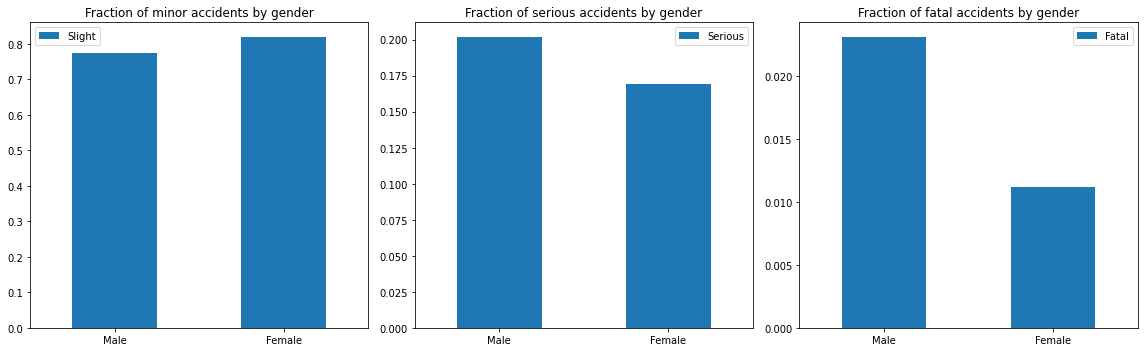

In [48]:
# copy the variables of interest into a new dataframe
dat = dat[['Accident_Severity', 'Sex_of_Driver']].dropna()

# calculate the fraction of each severity level per weekday
dat_count = dat.groupby(['Sex_of_Driver'])['Accident_Severity'].count()
dat_s1 = dat[dat['Accident_Severity'] == 1].groupby(['Sex_of_Driver'])['Accident_Severity'].count()
dat_s2 = dat[dat['Accident_Severity'] == 2].groupby(['Sex_of_Driver'])['Accident_Severity'].count()
dat_s3 = dat[dat['Accident_Severity'] == 3].groupby(['Sex_of_Driver'])['Accident_Severity'].count()

# create dataframe
grp_pct10 = pd.concat([dat_count, dat_s1 / dat_count, dat_s2 / dat_count, dat_s3 / dat_count], axis=1)
grp_pct10.columns = ['Total Accidents', 'Slight', 'Serious', 'Fatal']
grp_pct10.index = ['Male', 'Female']

# plots
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(16,5))
grp_pct10[['Slight']].plot.bar(ax=ax1, rot=0, title='Fraction of minor accidents by gender');
grp_pct10[['Serious']].plot.bar(ax=ax2, rot=0, title='Fraction of serious accidents by gender');
grp_pct10[['Fatal']].plot.bar(ax=ax3, rot=0, title='Fraction of fatal accidents by gender');
plt.tight_layout()

# print table
grp_pct10

We observe that male drivers indeed have higher fraction of *serious* and *fatal* car accidents, which supports Hypothesis #15. A possible explanation for this pattern could be that men tend to drive more aggressively and are more likely to be tempted towards speeding. Also, it could be that men, on average, drive cars with more power, and hence drive faster, which we will analyse next.

---

## Car engine power by gender

**Hypothesis #16**: Male car drivers drive higher-powered vehicles compared to female drivers.

We use the `Engine capacity (CC)` as proxy for the power of the car engine. Improved engine technology has allowed to extract more power at less displacement, i.e. via turbo chargers and hybrid technology, but since this technology is equally available to both genders, we assume that the distribution is the same for both genders.

Removed 3977118 rows because of missing Engine_Capacity_(CC) / or not a car
2272225 rows vehicle rows lefts


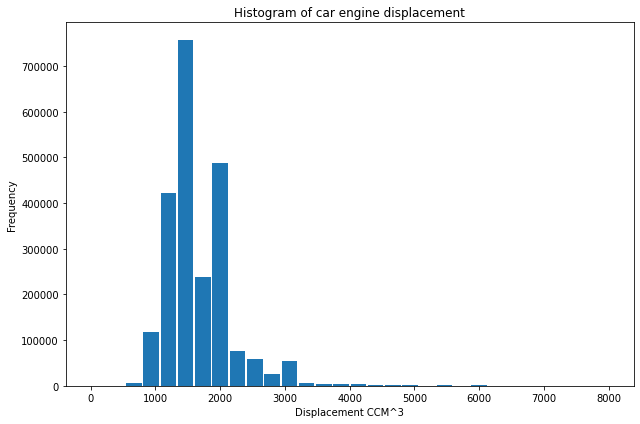

In [49]:
# filter missing Engine Capacity values, or vehicles which are not cars, or where gender is unknown
rm_veh = (veh['Engine_Capacity_(CC)'] <= 0) | (veh['Engine_Capacity_(CC)'] > 8000) | (veh['Vehicle_Type'] != 9) | (~veh['Sex_of_Driver'].isin([1, 2]))
dat = veh[~rm_veh].copy()

# sex of driver type number to label
dat.loc[:, 'Sex_of_Driver'] = dat.loc[:, 'Sex_of_Driver'].map(lambda x: 'Male' if x==1 else 'Female')

print(f'Removed {rm_veh.shape[0]} rows because of missing Engine_Capacity_(CC) / or not a car')
print(f'{dat.shape[0]} rows vehicle rows lefts')

# plot histogram of car engine displacement
fig, ax1 = plt.subplots(1,1, figsize=(9,6))
plt.hist(dat['Engine_Capacity_(CC)'], align='mid', rwidth=0.9, bins=30)  # `density=False` would make counts
plt.title('Histogram of car engine displacement')
plt.xlabel('Displacement CCM^3')
plt.ylabel('Frequency')
plt.tight_layout()

As expected, the majority of car engines have a displacement below 2 liters.

In [50]:
# calculate the mean engine capacity by sex of driver
dat_mean = dat.groupby(['Sex_of_Driver'])['Engine_Capacity_(CC)'].mean()
dat_std = dat.groupby(['Sex_of_Driver'])['Engine_Capacity_(CC)'].std()

pd.DataFrame([dat_mean, dat_std], index=['Mean capacity', 'Standard deviation'], columns=['Female', 'Male'])

,Female,Male
Mean capacity,1558.112704,1754.392122
Standard deviation,434.179527,535.571276


We found evidence for Hypothesis #16: The car engines of male drivers have a displacement of 1.75 l on average, and for female drivers it's 1.55 l on average. This is partial evidence why male drivers tend to be involved in more serious and fatal accidents, they choose to have higher-powered cars, and driving faster is a logical consequence of it.

---


## Hotspot detection and clustering

This analysis covers the question on where most of the traffic accidents happen in the country, and also on a more granular level. By choosing different clustering thresholds and zoom levels, we can show where traffic accidents hotspots are on a national level, as well as on a local/regional level.

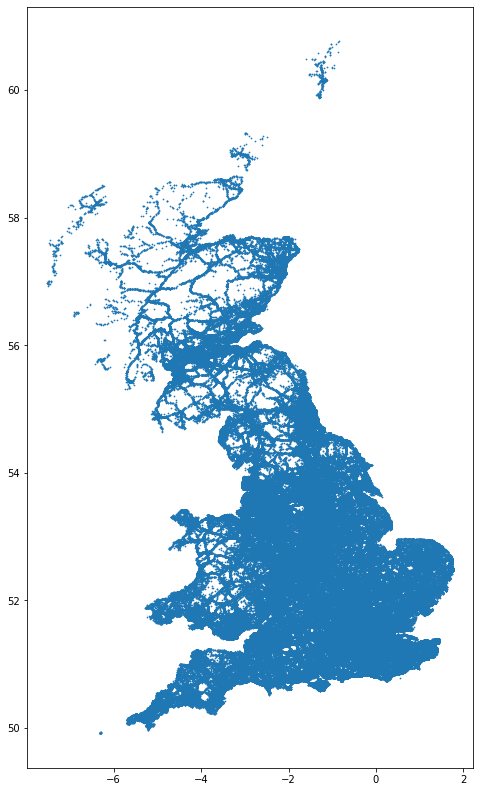

In [51]:
# copy columns coordinates and accident severity into new dataframe
dat_maps = acc[['Longitude', 'Latitude', 'Accident_Severity']].dropna()

# create simple plots using accident coordinates
fig, ax = plt.subplots(figsize=(8,14))
plt.scatter(x=dat_maps['Longitude'], y=dat_maps['Latitude'], s=0.5);

We immediately see by plotting all accidents in one plot as a tiny points that the road network in the north is way less developed, hence the area is less densly populated and has a lower density of accidents.

**Important**: The following analysis uses [kepler.gl](https://github.com/keplergl/kepler.gl/tree/master/bindings/kepler.gl-jupyter), which requires `node.js >10.15.0`, and two *Jupyer Lab* extensions to be installed. Also, due to the amount of data, the visualization requires a large amount of memory---we observed usage of up to 7 GB using *Firefox 74.0.1*.

Run the following commands in order to install dependencies and restart Jupyter Lab. We recommend using a dedicated Python 3 environment for a clear setup of Jupyter Lab and kepler.gl:

In [52]:
# !pip install keplergl
# !jupyter labextension install @jupyter-widgets/jupyterlab-manager keplergl-jupyter
# !jupyter labextension install @jupyter-widgets/jupyterlab-manager

In [53]:
from keplergl import KeplerGl

### Geospatial analysis on a national level for Scotland

For the geospatial analysis on a national level, in this case we will look at **Scotland**, we will only look at **fatal** accidents in order to simplify the analysis and reduce the amount of data processed. Another approach would be to sample from the original dataset for a broader analysis, which we won't do.

In [54]:
# kepler.gl configuration
cfg = {
  "version": "v1",
  "config": {
    "visState": {
      "filters": [],
      "layers": [
        {
          "id": "xdq9lbq",
          "type": "heatmap",
          "config": {
            "dataId": "data_1",
            "label": "Point",
            "color": [
              18,
              147,
              154
            ],
            "columns": {
              "lat": "Latitude",
              "lng": "Longitude"
            },
            "isVisible": True,
            "visConfig": {
              "opacity": 0.8,
              "colorRange": {
                "name": "Global Warming",
                "type": "sequential",
                "category": "Uber",
                "colors": [
                  "#5A1846",
                  "#900C3F",
                  "#C70039",
                  "#E3611C",
                  "#F1920E",
                  "#FFC300"
                ]
              },
              "radius": 10
            },
            "hidden": False,
            "textLabel": [
              {
                "field": None,
                "color": [
                  255,
                  255,
                  255
                ],
                "size": 18,
                "offset": [
                  0,
                  0
                ],
                "anchor": "start",
                "alignment": "center"
              }
            ]
          },
          "visualChannels": {
            "weightField": None,
            "weightScale": "linear"
          }
        }
      ],
      "interactionConfig": {
        "tooltip": {
          "fieldsToShow": {
            "data_1": [
              "Longitude",
              "Latitude",
              "Accident_Severity"
            ]
          },
          "enabled": True
        },
        "brush": {
          "size": 0.5,
          "enabled": False
        },
        "geocoder": {
          "enabled": False
        },
        "coordinate": {
          "enabled": False
        }
      },
      "layerBlending": "normal",
      "splitMaps": [],
      "animationConfig": {
        "currentTime": None,
        "speed": 1
      }
    },
    "mapState": {
      "bearing": 0,
      "dragRotate": False,
      "latitude": 56.36654894886892,
      "longitude": -4.296872226744527,
      "pitch": 0,
      "zoom": 7.014431228409396,
      "isSplit": False
    },
    "mapStyle": {
      "styleType": "dark",
      "topLayerGroups": {},
      "visibleLayerGroups": {
        "label": True,
        "road": True,
        "border": False,
        "building": True,
        "water": True,
        "land": True,
        "3d building": False
      },
      "threeDBuildingColor": [
        9.665468314072013,
        17.18305478057247,
        31.1442867897876
      ],
      "mapStyles": {}
    }
  }
}

# filter for fatal accidents only
dat_map = dat_maps[dat_maps['Accident_Severity'] == 3]

# create kepler.gl viewport using filtered data and configuration
kmap = KeplerGl(height=1000, data={'data_1': dat_map}, config=cfg)
kmap.save_to_html(data={'data_1': dat_map}, config=cfg, file_name='map_export_Scotland.html')
kmap

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to map_export_Scotland.html!


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'xdq9lbq', 'type': …

Looking at the heatmap of Scotland, immediately and unsurprisingly we can spot that big cities like Glasgow and Aberdeen are hotspots of fatal accidents.

What is more interesting though is to see the distribution of accidents along roads like highways, where we can spot clusters of accidents. Once we have located a point of interest, we can simply zoom in in kepler.gl and further analyze the distribution of accidents in more detail.

### Geospatial analysis on a local level for the City of London

In another example, we will take a closer look at the **City of London**, where we can see single intersections, roundabouts, and differentiate between roads. We will do this for accidents of type **serious** (we looked at *fatal* accidents in the Scotland analysis).

In [55]:
cfg = {
  "version": "v1",
  "config": {
    "visState": {
      "filters": [],
      "layers": [
        {
          "id": "xdq9lbq",
          "type": "heatmap",
          "config": {
            "dataId": "data_1",
            "label": "Point",
            "color": [
              18,
              147,
              154
            ],
            "columns": {
              "lat": "Latitude",
              "lng": "Longitude"
            },
            "isVisible": True,
            "visConfig": {
              "opacity": 0.8,
              "colorRange": {
                "name": "Global Warming",
                "type": "sequential",
                "category": "Uber",
                "colors": [
                  "#5A1846",
                  "#900C3F",
                  "#C70039",
                  "#E3611C",
                  "#F1920E",
                  "#FFC300"
                ]
              },
              "radius": 5
            },
            "hidden": False,
            "textLabel": [
              {
                "field": None,
                "color": [
                  255,
                  255,
                  255
                ],
                "size": 18,
                "offset": [
                  0,
                  0
                ],
                "anchor": "start",
                "alignment": "center"
              }
            ]
          },
          "visualChannels": {
            "weightField": None,
            "weightScale": "linear"
          }
        }
      ],
      "interactionConfig": {
        "tooltip": {
          "fieldsToShow": {
            "data_1": [
              "Longitude",
              "Latitude",
              "Accident_Severity"
            ]
          },
          "enabled": True
        },
        "brush": {
          "size": 0.5,
          "enabled": False
        },
        "geocoder": {
          "enabled": False
        },
        "coordinate": {
          "enabled": False
        }
      },
      "layerBlending": "normal",
      "splitMaps": [],
      "animationConfig": {
        "currentTime": None,
        "speed": 1
      }
    },
    "mapState": {
      "bearing": 0,
      "dragRotate": False,
      "latitude": 51.51118725733577,
      "longitude": -0.10874324537290832,
      "pitch": 0,
      "zoom": 13.470626352492722,
      "isSplit": False
    },
    "mapStyle": {
      "styleType": "dark",
      "topLayerGroups": {},
      "visibleLayerGroups": {
        "label": True,
        "road": True,
        "border": False,
        "building": True,
        "water": True,
        "land": True,
        "3d building": False
      },
      "threeDBuildingColor": [
        9.665468314072013,
        17.18305478057247,
        31.1442867897876
      ],
      "mapStyles": {}
    }
  }
}

# filter for serious accidents only
dat_map = dat_maps[dat_maps['Accident_Severity'] == 2]

# filter by latitude / longitude to reduce size of dataset
dat_map = dat_map[(dat_map['Latitude'] < 51.6) & (dat_map['Latitude'] > 51.4)]
dat_map = dat_map[(dat_map['Longitude'] < 0.1) & (dat_map['Longitude'] > -0.4)]

# create kepler.gl viewport using filtered data and configuration
kmap = KeplerGl(height=1000, data={'data_1': dat_map}, config=cfg)
kmap.save_to_html(data={'data_1': dat_map}, config=cfg, file_name='map_export_London.html')
kmap

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to map_export_London.html!


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'xdq9lbq', 'type': …

The heatmap shows that intersections are especially prone to serious accidents, e.g. see Holborn, or Charing Cross close to Trafalgar Square. Also, the intersections on/off bridges show hotspots too. One thing to keep in mind though is that intersections naturally have higher traffic volumes compared to streets, because they intersect traffic streams from different streets. Furthermore, apart from the intersections, it is easy to spot streets and locations in general with higher density of serious traffic accidents. This is usefull information for road safety work and road planning.

## Statistical Modeling

The previous analyses were mostly in the domain of descriptive and exploratory data analysis. In the last part of our data analysis project, we are going to predict accident severity of single-vehicle accidents (Selbstunfälle), using a subset of the available data. For this purpose, we will employ a multilayer perceptron neural network, which is capable of modeling high-dimensional data with non-linear relationships. The resulting network is not of direct use, because its internal workings are not easily interpretable, so only the prediction aspect is relevant and mostly for illustrative purposes. Other models like regression trees or random forests would allow us to gain more insights, i.e. variable importance measures, or even looking at the decision tree directly, but have shown to be worse at predicting than the MLP neural network.

In [56]:
# filter out vehicles with more than one vehicle/driver involved
rm_idxs = veh[['Accident_Index']].duplicated(keep=False)
dat = veh[~rm_idxs].copy()
print(f'Filtered out {rm_idxs.sum()} vehicle rows because of multiple drivers involved')

# filter out vehicles with unknown driver age
rm_idxs = dat['Age_of_Driver'] < 16 | dat['Age_of_Driver'].isna()
dat = dat[~rm_idxs]
print(f'Filtered out {rm_idxs.sum()} vehicle rows because of missing/invalid driver age')

# filter out vehicles with unknown driver sex
rm_idxs = ~dat['Sex_of_Driver'].isin([1,2])
dat = dat[~rm_idxs]
print(f'Filtered out {rm_idxs.sum()} vehicle rows because of unknown driver sex')

# only look at car accidents
rm_idxs = dat['Vehicle_Type'] != 9
dat = dat[~rm_idxs]
print(f'Filtered out {rm_idxs.sum()} vehicle rows because of vehicle is not a car')

# map age to age bins
agebins = ['<=25','26-35','36-45','46-60','61-75','76+']

def age_bin(age):
  if age <= 25:
    return 0
  elif age <= 35:
    return 1
  elif age <= 45:
    return 2
  elif age <= 60:
    return 3
  elif age <= 75:
    return 4
  else:
    return 5
dat['Age Bin'] = dat['Age_of_Driver'].apply(age_bin)

# filter out accidents with unknown weather conditions
rm_idxs = acc['Weather_Conditions'] == -1
dat2 = acc[~rm_idxs]
print(f'Filtered out {rm_idxs.sum()} accident rows because of unknown weather conditions')

# filter out accidents with unknown road surface conditions
rm_idxs = dat2['Road_Surface_Conditions'] == -1
dat2 = dat2[~rm_idxs]
print(f'Filtered out {rm_idxs.sum()} accident rows because of unknown road surface conditions')

# join Accidents and Vehicles
dat = pd.merge(dat2, dat, on='Accident_Index', how='inner')

# extract features and labels for Random Forest model
dat = dat[['Accident_Severity', 'Light_Conditions', 'Weather_Conditions',
           'Road_Surface_Conditions', 'Hour of Day', 'Day of Week',
           'Sex_of_Driver', 'Age_of_Driver', 'Speed_limit', 'Engine_Capacity_(CC)']].dropna()

# sample uniformly for each accident severity (1,2,3).
# we need to sample separately in order to get same count
# for each accident severity so that the model is not biased towards
# fitting more frequently occuring accident severities.

dat_rf = pd.concat([dat[dat['Accident_Severity'] == 1].sample(20000, replace=True),
                    dat[dat['Accident_Severity'] == 2].sample(20000, replace=True),
                    dat[dat['Accident_Severity'] == 3].sample(20000, replace=True)], ignore_index=True)
dat_rf.reset_index(drop=True, inplace=True)

# labels and features
y = dat_rf.iloc[:, 0]
X = dat_rf.iloc[:, 1:len(dat_rf.columns)]
X_onehot = pd.get_dummies(X, columns=['Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions', 'Hour of Day', 'Day of Week', 'Sex_of_Driver'])
print(f'{X_onehot.shape[0]} rows used for statistical modeling')

Filtered out 3324152 vehicle rows because of multiple drivers involved
Filtered out 74776 vehicle rows because of missing/invalid driver age
Filtered out 3375 vehicle rows because of unknown driver sex
Filtered out 164676 vehicle rows because of vehicle is not a car
Filtered out 193 accident rows because of unknown weather conditions
Filtered out 6279 accident rows because of unknown road surface conditions
60000 rows used for statistical modeling


In [58]:
# !pip install tensorflow
# !pip install keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report

# split data into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X_onehot, y, test_size=0.3, random_state=42)

# rescale features
scaler = StandardScaler().fit(X_onehot)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)  

# one-hot encode response - accident severity (1,2,3)
y_encoder = OneHotEncoder()
y_encoder.fit(y_train.values.reshape(-1,1))
y_train_onehot = y_encoder.transform(y_train.values.reshape(-1,1)).toarray()

# define neural network model structure
model = Sequential()
model.add(Dense(100, input_dim=55, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(40, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# early stopping to prevent overfit
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

# fit model
history = model.fit(X_train, y_train_onehot, validation_split=0.2, epochs=100, batch_size=50, verbose=1, callbacks=[early_stop])

Train on 33600 samples, validate on 8400 samples
Epoch 1/100
33600/33600 [==============================] - 1s 40us/step - loss: 1.0683 - accuracy: 0.4272 - val_loss: 1.0431 - val_accuracy: 0.4446
Epoch 2/100
33600/33600 [==============================] - 1s 38us/step - loss: 1.0414 - accuracy: 0.4493 - val_loss: 1.0321 - val_accuracy: 0.4529
Epoch 3/100
33600/33600 [==============================] - 1s 37us/step - loss: 1.0326 - accuracy: 0.4566 - val_loss: 1.0304 - val_accuracy: 0.4579
Epoch 4/100
33600/33600 [==============================] - 1s 37us/step - loss: 1.0283 - accuracy: 0.4626 - val_loss: 1.0289 - val_accuracy: 0.4562
Epoch 5/100
33600/33600 [==============================] - 1s 36us/step - loss: 1.0230 - accuracy: 0.4676 - val_loss: 1.0255 - val_accuracy: 0.4602
Epoch 6/100
33600/33600 [==============================] - 1s 36us/step - loss: 1.0206 - accuracy: 0.4709 - val_loss: 1.0256 - val_accuracy: 0.4569
Epoch 7/100
33600/33600 [==============================] - 1s 3

              precision    recall  f1-score   support

           1       0.45      0.41      0.43      6014
           2       0.40      0.45      0.42      5987
           3       0.57      0.56      0.56      5999

    accuracy                           0.47     18000
   macro avg       0.47      0.47      0.47     18000
weighted avg       0.47      0.47      0.47     18000



Predicted,1,2,3,All
True,,,,
1,2456,2345,1213,6014
2,1965,2677,1345,5987
3,1011,1620,3368,5999
All,5432,6642,5926,18000


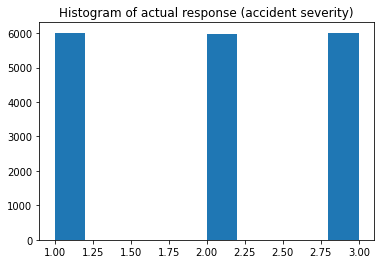

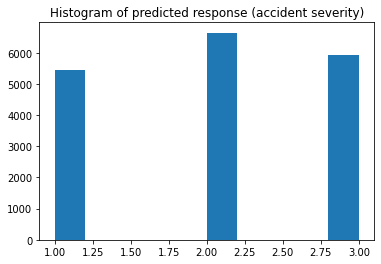

In [59]:
# predict on test data
y_pred = model.predict_classes(X_test) + 1

# histograms of response predicted vs. actual
y_test.hist()
plt.grid(False)
plt.title('Histogram of actual response (accident severity)')

pd.DataFrame(y_pred).hist()
plt.grid(False)
plt.title('Histogram of predicted response (accident severity)')

# classification report
print(classification_report(y_test, y_pred))

# confusion matrix
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

The multilayer perceptron neural network with 3 layers (100, 20 and 3 neurons) is able to predict accident severity given conditions like speed limit, weather, light, age, engine displacement, sex of driver, day of week, and hour of day---not with high accuracy, but better than random guesses. Due to the nature of neural networks, we cannot easily identify which variables have the most predictive power; a regression tree or random forest for example would allow this, but show worse predictive performance.

Looking at the confusion matrix above the two histograms, we observe that it is diagonal heavy, hence it has some predictive power, though not with very high accuracy. It is comparatively good at predicting fatal accidents (3), being right 68% of the times it predicts a fatal accident.

## Summary

We showed with this analysis the abundant information embedded in the raw datasets. These insights can be used for road safety measures, pricing policies, detection of dangerous accident hotspots, driver behaviour, and other safety relevant topics which may safe lives.

Based on our insights and for illustrative purposes, we make the following proposals in order to increase road safety:

- Dynamic speed limits on highways/motorways so that they can be lowered during bad weather conditions, i.e. fog.
- Elderly drivers undergo fitness tests to asses their capabilities for driving a car, i.e. reaction time, vision and strength.
- Limitation of maximum engine power for drivers aged <=25 in order to decrease severity of accidents.
- Popular motorcycle routes during the weekend should be checked more often by the police, if they don't have this policy yet.
- Further investigation into the causes of accidents during the night (12 PM - 5 AM).

# Declaration

We hereby declare by the submission of this Jupyter notebook as part of the graded project of the course that all text and code (apart from standard boilerplate code snippets) contained in this Jupyter Notebook have been written by ourselves without the help of other parties.